In [1]:
from PortfolioHandler import *

In [2]:
p=Portfolio()

In [3]:
p.get_data_list(3000)

In [4]:
p.get_matrix('open')
p.get_matrix('high')
p.get_matrix('low')
p.get_matrix('close')
p.get_matrix('amount')

In [5]:
h=p.matrix_list['high']
l=p.matrix_list['low']
c=p.matrix_list['close']
v=p.matrix_list['amount']

### The Hot Chaser

,zecusdt,nexousdt,waxpusdt,oneusdt
id,,,,
2021-10-26 16:00:00,1.0,0.0,0.0,0.0
2021-10-27 16:00:00,1.0,0.0,0.0,0.0
2021-10-28 16:00:00,1.0,0.0,0.0,0.0
2021-10-29 16:00:00,0.0,0.0,0.0,1.0
2021-10-30 16:00:00,1.0,0.0,0.0,1.0
2021-10-31 16:00:00,1.0,0.0,0.0,1.0
2021-11-01 16:00:00,0.0,1.0,0.0,1.0
2021-11-02 16:00:00,0.0,1.0,0.0,1.0
2021-11-03 16:00:00,0.0,1.0,0.0,0.0


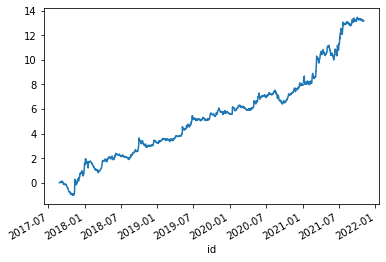

In [170]:
nif=net_inflow(h,l,c,v,14)
rs=relative_strength(c,14)
rt=c.pct_change(1).fillna(0)
rt10=c.pct_change(10).fillna(0)
factor=rank_matrix(rt)+rank_matrix(nif)+rank_matrix(rs)
b=rank_to_signal(factor.rolling(14).mean(),1)
ma=moving_average(c,3)
s=cross_over(ma,c)
position=signal_to_position(b,s)
summary(position,c)

### The Silence Jumper

,faireth,arpaht,titaneth,astusdt,masseth,sspbtc,embtc,waxpusdt,shibusdt,gsceth
id,,,,,,,,,,
2021-10-26 16:00:00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2021-10-27 16:00:00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2021-10-28 16:00:00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2021-10-29 16:00:00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2021-10-30 16:00:00,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2021-10-31 16:00:00,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2021-11-01 16:00:00,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2021-11-02 16:00:00,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-11-03 16:00:00,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


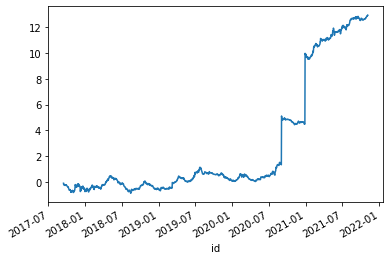

In [174]:
nif=net_inflow(h,l,c,v,14)
factor=rank_matrix(nif.pct_change(21))
b=rank_to_signal(factor.rolling(14).mean(),1)
ma=moving_average(c,20)
s=cross_over(ma,c)
position=signal_to_position(b,s)
summary(position,c)